<a href="https://colab.research.google.com/github/Abhip97/Bccd_object_detection_app/blob/main/Object_detection_bccd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection using BCCD dataset

## Step 1: Import dataset to google collab


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving BCCD.v3-raw.yolov10.zip to BCCD.v3-raw.yolov10.zip


In [ ]:
# Step 2: move dataset to working directory
import shutil
import os

dataset_zip = "BCCD.v3-raw.yolov10.zip"  # Change if your filename is different
dataset_dir = "/content/BCCD_Dataset"

# Unzip the dataset
shutil.unpack_archive(dataset_zip, dataset_dir)

# Check files
os.listdir(dataset_dir)


['data.yaml',
 'valid',
 'README.dataset.txt',
 'train',
 'README.roboflow.txt',
 'test']

In [ ]:
# step 3: Install Yolov10
!pip install ultralytics opencv-python albumentations


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 109.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [ ]:
# Step 4: Image preprocessing
import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import numpy as np
import os
import torch

# Define augmentation techniques
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),        # Flip image horizontally
    A.Rotate(limit=15, p=0.5),       # Rotate up to 15 degrees
    A.RandomCrop(height=224, width=224, p=0.5),  # Randomly crop image
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize
    ToTensorV2()
])

# Paths
train_images_path = f"{dataset_dir}/train/images"
augmented_path = f"{dataset_dir}/train/augmented_images"

# Create folder for augmented images
os.makedirs(augmented_path, exist_ok=True)

# Apply augmentation to training images
for img_filename in os.listdir(train_images_path):
    img_path = os.path.join(train_images_path, img_filename)

    # Read image using OpenCV
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Apply augmentation
    augmented = augmentations(image=img)['image']

    # Convert Tensor (C, H, W) → NumPy (H, W, C)
    augmented_np = augmented.permute(1, 2, 0).cpu().numpy()  # Convert to NumPy
    augmented_np = (augmented_np * 255).astype(np.uint8)  # Convert to uint8 format

    # Save augmented image
    Image.fromarray(augmented_np).save(os.path.join(augmented_path, img_filename))

print("Data Augmentation Completed and Augmented images saved.")


Data Augmentation Completed and Augmented images saved.


In [ ]:
# Step 5: Train the YOLOv10 Model on the Augmented Dataset
from ultralytics import YOLO

# Load YOLOv10 model
model = YOLO("yolov10n.pt")  # YOLOv10 Nano model

# Train the model using augmented dataset
model.train(
    data=f"{dataset_dir}/data.yaml",
    epochs=50,
    imgsz=640,  # Image size
    batch=16,
    device="cuda"  # Uses GPU if available
)

# Save trained model
model.save("best_yolov10.pt")
print("Training Complete! Model saved as best_yolov10.pt")


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 5.59M/5.59M [00:00<00:00, 104MB/s]


Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/BCCD_Dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 27.0MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1      9856  ultralytics.nn.modules.block.SCDown          [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1     36096  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 95.4MB/s]


AMP: checks passed ✅


train: Scanning /content/BCCD_Dataset/train/labels... 255 images, 0 backgrounds, 0 corrupt: 100%|██████████| 255/255 [00:00<00:00, 1576.49it/s]

train: New cache created: /content/BCCD_Dataset/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/BCCD_Dataset/valid/labels... 73 images, 0 backgrounds, 0 corrupt: 100%|██████████| 73/73 [00:00<00:00, 682.47it/s]

val: New cache created: /content/BCCD_Dataset/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      3.05G      2.691      6.851      2.858        352        640: 100%|██████████| 16/16 [00:07<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.90it/s]

                   all         73        967     0.0279      0.611      0.142     0.0944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      3.07G      2.394      4.909       2.32        339        640: 100%|██████████| 16/16 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all         73        967     0.0263      0.646      0.421      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      3.22G      2.426      3.681      2.355        318        640: 100%|██████████| 16/16 [00:04<00:00,  3.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.44it/s]

                   all         73        967      0.028      0.663      0.482      0.353



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      3.23G      2.369      2.994      2.412        314        640: 100%|██████████| 16/16 [00:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]

                   all         73        967     0.0244      0.665      0.432      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      3.25G       2.32      2.726      2.369        347        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.26it/s]

                   all         73        967      0.896      0.227      0.472       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50       3.4G      2.348      2.627      2.402        281        640: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.49it/s]


                   all         73        967      0.861       0.37      0.655      0.452

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      3.55G      2.313      2.476      2.322        273        640: 100%|██████████| 16/16 [00:04<00:00,  3.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.49it/s]

                   all         73        967      0.767      0.495      0.641      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      3.57G      2.292      2.437      2.336        337        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.00it/s]

                   all         73        967      0.828       0.51      0.676      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      3.58G        2.3      2.409      2.331        274        640: 100%|██████████| 16/16 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

                   all         73        967      0.619      0.746      0.775      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50       3.6G      2.316      2.346      2.329        395        640: 100%|██████████| 16/16 [00:04<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

                   all         73        967      0.685      0.739      0.774      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      3.62G      2.256      2.201      2.282        446        640: 100%|██████████| 16/16 [00:05<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all         73        967      0.669      0.794      0.776      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      3.63G      2.237      2.183      2.277        393        640: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.71it/s]

                   all         73        967      0.697      0.769      0.801      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      3.65G       2.25      2.122      2.281        362        640: 100%|██████████| 16/16 [00:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

                   all         73        967      0.699       0.82      0.841      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      3.66G      2.272      2.111      2.262        449        640: 100%|██████████| 16/16 [00:04<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         73        967      0.714      0.823      0.825      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      3.68G      2.231      2.066       2.27        352        640: 100%|██████████| 16/16 [00:05<00:00,  2.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         73        967      0.673      0.802      0.787      0.531



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      3.69G      2.204      1.998      2.287        343        640: 100%|██████████| 16/16 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.85it/s]

                   all         73        967      0.709       0.82      0.848      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      3.71G      2.256      2.031      2.277        376        640: 100%|██████████| 16/16 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.62it/s]


                   all         73        967      0.719      0.841       0.85      0.586

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      3.87G      2.219      1.984      2.269        359        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.96it/s]

                   all         73        967      0.799      0.798      0.863      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      3.88G      2.178       1.94      2.264        308        640: 100%|██████████| 16/16 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.18it/s]

                   all         73        967      0.765      0.812      0.868      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50       3.9G      2.163      1.893      2.249        351        640: 100%|██████████| 16/16 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]

                   all         73        967      0.751      0.818      0.843      0.579



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      3.91G      2.191      1.942      2.298        352        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]

                   all         73        967      0.722      0.785      0.835      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      3.93G      2.178      1.882      2.245        320        640: 100%|██████████| 16/16 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.89it/s]

                   all         73        967      0.768      0.816      0.863      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      3.95G      2.107      1.859      2.243        363        640: 100%|██████████| 16/16 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         73        967      0.811      0.838      0.877      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      3.96G      2.114      1.829      2.214        365        640: 100%|██████████| 16/16 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.40it/s]

                   all         73        967      0.734      0.847      0.863      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      3.98G      2.083      1.791      2.235        373        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.81it/s]

                   all         73        967      0.755      0.808      0.848      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      3.99G      2.111      1.753      2.205        314        640: 100%|██████████| 16/16 [00:05<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.53it/s]

                   all         73        967      0.786      0.827      0.885      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      4.01G      2.104      1.803      2.226        358        640: 100%|██████████| 16/16 [00:04<00:00,  3.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.78it/s]

                   all         73        967      0.769      0.801      0.873      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      4.02G      2.102      1.705      2.204        337        640: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.19it/s]

                   all         73        967      0.799      0.837      0.883      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      4.04G      2.042      1.727      2.199        380        640: 100%|██████████| 16/16 [00:04<00:00,  3.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all         73        967      0.814      0.826      0.879      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      4.05G      2.075      1.699      2.208        368        640: 100%|██████████| 16/16 [00:04<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.29it/s]

                   all         73        967      0.759      0.887      0.879      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      4.07G      2.056      1.701      2.199        386        640: 100%|██████████| 16/16 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.17it/s]

                   all         73        967      0.797      0.863      0.889      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      4.08G      2.066      1.679      2.202        418        640: 100%|██████████| 16/16 [00:04<00:00,  3.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.52it/s]

                   all         73        967      0.786      0.858      0.888      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50       4.1G      2.062      1.674      2.206        304        640: 100%|██████████| 16/16 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.84it/s]

                   all         73        967      0.813      0.825      0.885      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      4.12G      2.012      1.618      2.159        393        640: 100%|██████████| 16/16 [00:04<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.72it/s]

                   all         73        967      0.788       0.87      0.887       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      4.13G      1.995      1.612      2.175        274        640: 100%|██████████| 16/16 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.88it/s]

                   all         73        967      0.782      0.843      0.885      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      4.15G      2.039      1.579      2.164        412        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.68it/s]

                   all         73        967      0.813      0.874      0.894      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      4.16G       1.96       1.55      2.144        320        640: 100%|██████████| 16/16 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.34it/s]

                   all         73        967      0.868      0.806      0.892      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      4.18G      1.981       1.52      2.163        336        640: 100%|██████████| 16/16 [00:04<00:00,  3.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.83it/s]

                   all         73        967       0.81      0.848      0.883      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50       4.2G      1.978      1.548      2.153        367        640: 100%|██████████| 16/16 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.52it/s]

                   all         73        967      0.799      0.864      0.886      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      4.21G      1.946      1.516      2.137        396        640: 100%|██████████| 16/16 [00:04<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.79it/s]

                   all         73        967       0.82      0.823      0.886      0.635


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      4.22G       1.94      1.737      2.161        192        640: 100%|██████████| 16/16 [00:06<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.35it/s]

                   all         73        967        0.8      0.859      0.882      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      4.24G      1.948       1.63      2.169        185        640: 100%|██████████| 16/16 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.97it/s]

                   all         73        967       0.82      0.854      0.883       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      4.25G      1.933      1.549      2.149        196        640: 100%|██████████| 16/16 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.17it/s]

                   all         73        967      0.767      0.869      0.875      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      4.27G      1.868      1.457      2.138        207        640: 100%|██████████| 16/16 [00:04<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.75it/s]

                   all         73        967      0.763      0.891       0.88      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      4.29G      1.885      1.479      2.172        204        640: 100%|██████████| 16/16 [00:04<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.42it/s]

                   all         73        967      0.833      0.823      0.884      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50       4.3G      1.844      1.418      2.124        177        640: 100%|██████████| 16/16 [00:04<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.87it/s]

                   all         73        967      0.814      0.835      0.889      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      4.32G      1.859      1.404      2.138        196        640: 100%|██████████| 16/16 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.73it/s]

                   all         73        967       0.79      0.852      0.891       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      4.33G      1.824      1.391      2.142        214        640: 100%|██████████| 16/16 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.66it/s]

                   all         73        967      0.807      0.824       0.89      0.642



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      4.35G      1.809      1.344       2.13        192        640: 100%|██████████| 16/16 [00:04<00:00,  3.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.69it/s]

                   all         73        967      0.773      0.869       0.89      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      4.36G      1.804      1.365      2.115        193        640: 100%|██████████| 16/16 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.37it/s]

                   all         73        967      0.786      0.871      0.891      0.645



50 epochs completed in 0.095 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.7MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 125 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.93it/s]


                   all         73        967      0.787      0.874      0.891      0.645
             Platelets         42         76      0.726      0.836      0.843      0.504
                   RBC         72        819      0.735      0.827      0.855       0.62
                   WBC         71         72        0.9      0.958      0.974      0.812
Speed: 0.4ms preprocess, 3.6ms inference, 0.0ms loss, 0.5ms postprocess per image
Results saved to runs/detect/train
Training Complete! Model saved as best_yolov10.pt



image 1/1 /content/BCCD_Dataset/test/images/BloodImage_00044_jpg.rf.589ee3d351cb6d9a3f7b7a942da5370a.jpg: 480x640 4 Plateletss, 18 RBCs, 2 WBCs, 23.0ms
Speed: 2.1ms preprocess, 23.0ms inference, 0.6ms postprocess per image at shape (1, 3, 480, 640)


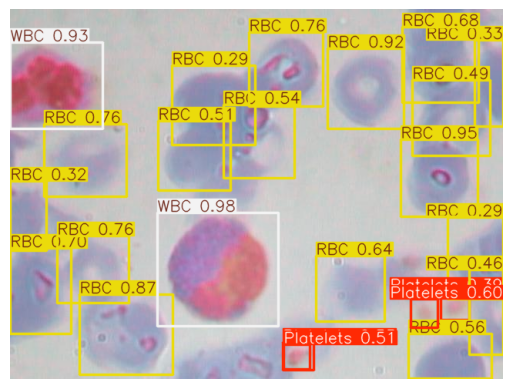

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'Platelets', 1: 'RBC', 2: 'WBC'}
obb: None
orig_img: array([[[184, 188, 183],
        [183, 187, 182],
        [181, 187, 182],
        ...,
        [192, 188, 194],
        [189, 187, 193],
        [189, 187, 193]],

       [[184, 188, 183],
        [183, 187, 182],
        [181, 187, 182],
        ...,
        [192, 188, 194],
        [190, 188, 194],
        [189, 187, 193]],

       [[184, 188, 183],
        [183, 187, 182],
        [181, 187, 182],
        ...,
        [192, 188, 194],
        [192, 188, 194],
        [191, 187, 193]],

       ...,

       [[197, 200, 198],
        [196, 199, 197],
        [195, 198, 196],
        ...,
        [199, 204, 202],
        [201, 205, 200],
        [201, 205, 200]],

       [[195, 200, 198],
        [194, 199, 197],
        [193, 198, 196],
        ...,
        [199, 204, 202],
        [199, 2

In [ ]:
# Step 6: Model Infernce
import torch
import matplotlib.pyplot as plt

# Load the fine-tuned model
model = YOLO("best_yolov10.pt")

def detect_objects(image_path):

    # Run inference
    results = model(image_path)

    # Retrieve the first result from the list
    result = results[0]

    # Plot the image with bounding boxes
    plt.imshow(result.plot())
    plt.axis("off")
    plt.show()

    return result

# Test the function on a new image
test_img = f"{dataset_dir}/test/images/BloodImage_00044_jpg.rf.589ee3d351cb6d9a3f7b7a942da5370a.jpg"
detect_objects(test_img)



In [ ]:
# Step 7: Export model
from ultralytics import YOLO

# Load trained YOLO model
model = YOLO("best_yolov10.pt")

# Export to ONNX format
model.export(format="onnx")


Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CPU (Intel Xeon 2.00GHz)
YOLOv10n summary (fused): 125 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs

PyTorch: starting from 'best_yolov10.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 300, 6) (5.5 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 223.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.9/142.9 kB 336.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.8/280.8 MB 217.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 210.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 318.4 MB/s eta 0:00:00

requirements: AutoUpdate success ✅ 17.4s, installed 3 packages: ['onnx>=1.12.0', 'onnxslim', 'onnxruntime-gpu']
requirements: ⚠️ Restart runtime or rerun command for updates to take effec

'best_yolov10.onnx'